In [1]:
import pickle as pkl    
import os
from pcdet.ops.iou3d_nms import iou3d_nms_utils
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

import torch
os.chdir('/home/cgriesbacher/thesis/3DTrans/')

### Init functions

In [17]:
def calc_ious(pseudo_labels, gt_labels):
    #pseudo_labels = pseudo_labels.copy()
    #gt_labels = gt_labels.copy()
    #add iou score to the dataframe, default is 0 , use .loc[row_indexer,col_indexer] = value instead
    pseudo_labels['iou'] = 0
    gt_labels['iou'] = 0
    pseudo_labels['true_label'] = "Background"

    #det detection frame ids
    ps_frame_ids = pseudo_labels['frame_id'].unique()

    num_no_labels = 0
    num_label = 0
    # Loop over all frames
    pbar = tqdm.tqdm(ps_frame_ids)
    for ps_frame_id in pbar:

        gt_labels_frame = gt_labels[gt_labels['frame_id'] == ps_frame_id]
        pseudo_labels_frame = pseudo_labels[pseudo_labels['frame_id'] == ps_frame_id]

        if len(gt_labels_frame) == 0 or len(pseudo_labels_frame) == 0:
            #print(f"Frame {ps_frame_id} has no gts or no detections")
            num_no_labels += 1
            no_label_perc = round((num_no_labels/(num_label+num_no_labels)* 100),2) 
            pbar.set_description(f"No label percentage: {no_label_perc}%")
            continue
        else:
            num_label += 1

        # Convert the boxes to numpy
        gt_boxes_frame = np.stack(gt_labels_frame["gt_boxes_lidar"].values)
        ps_boxes_frame = np.stack(pseudo_labels_frame["boxes_lidar"].values)

        #iou_matrix = iou3d_nms_utils.boxes_iou3d_gpu(torch.tensor(gt_boxes_frame, dtype=torch.float, device='cuda'), torch.tensor(ps_boxes_frame, dtype=torch.float, device='cuda')).cpu().numpy()
        iou_matrix = iou3d_nms_utils.boxes_iou_bev(torch.tensor(gt_boxes_frame, dtype=torch.float, device='cuda'), torch.tensor(ps_boxes_frame, dtype=torch.float, device='cuda')).cpu().numpy()
        #iou_matrix = iou3d_nms_utils.boxes_bev_iou_cpu(gt_boxes_frame, ps_boxes_frame)
        
        # Get the max iou for each det box
        max_ious_ps = np.max(iou_matrix, axis=0)
        max_ious_ps_idx = np.argmax(iou_matrix, axis=0)

        # get class for each detection
        cls_dets = gt_labels_frame['names'].values[max_ious_ps_idx]
        
        # Update the iou score for each detection in the original DataFrame
        pseudo_labels.loc[pseudo_labels_frame.index, 'iou'] = max_ious_ps

        #TODO: only update label if it is higher than 0!!
        pseudo_labels.loc[pseudo_labels_frame.index, 'true_label'] = cls_dets
        # print(f"Percentage of detection ious greater than 0: {round(len(max_ious_ps[max_ious_ps > 0])/len(max_ious_ps),2)}")

        # Get max_iou for each gt box
        max_ious_gts = np.max(iou_matrix, axis=1)

        # Update the iou score for each gt in the original DataFrame
        gt_labels.loc[gt_labels_frame.index, 'iou'] = max_ious_gts
        #percentage of ious that are greater than 0
        # print(f"Percentage of gt ious greater than 0: {round(len(max_ious_gts[max_ious_gts > 0])/len(max_ious_gts),2)}")

        # XXX: only update if score is higher than current score


    iou_thresholds = [0.1, 0.3, 0.5, 0.7]

    #for each detection, add detected_0.3, detected_0.5, detected_0.7
    for iou_threshold in iou_thresholds:
        pseudo_labels[f'detected_{iou_threshold}'] = pseudo_labels['iou'] >= iou_threshold
        gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold

    return pseudo_labels, gt_labels

def load_pseudo_labels(path, df, train_dataset=None, eval_dataset=None, epoch=None):
    label_map = {
        1: "Vehicle",
        2: "Pedestrian",
        3: "Cyclist",
        4: "Truck",
        -1: "Unsure",
        #'Placeholder': 'DontCare',
    }
    with open(path, 'rb') as f:
        pseudo_labels = pkl.load(f)

    #add key as dict entry "frame_id"
    for frame_id in pseudo_labels:
        pseudo_labels[frame_id]['frame_id'] = frame_id
    
    #convert to dicts to list
    pseudo_labels_frames = list(pseudo_labels.values())
    
    scores = []
    names = []
    boxes_lidar = []
    frame_ids = []

    for frame_i in range(len(pseudo_labels_frames)):
        for det_i in range(pseudo_labels_frames[frame_i]['gt_boxes'].shape[0]):
            scores.append(pseudo_labels_frames[frame_i]['gt_boxes'][det_i][-1])
            names.append(label_map[int(pseudo_labels_frames[frame_i]['gt_boxes'][det_i][-2])])
            boxes_lidar.append(pseudo_labels_frames[frame_i]['gt_boxes'][det_i][:-2])
            frame_ids.append(frame_i)

    #lists to dataset
    pseudo_labels = {'score': scores, 'name': names, 'boxes_lidar': boxes_lidar, 'frame_id': frame_ids}

    #make a dataframe
    pseudo_labels = pd.DataFrame(pseudo_labels)

    #get datasset name from path
    if eval_dataset == None:
        eval_dataset = path.split('/')[-2]
    if train_dataset == None:
        train_dataset = path.split('/')[-8].split('_')[0]

    # add a column with the dataset name
    pseudo_labels['eval_dataset'] = eval_dataset
    pseudo_labels['train_dataset'] = train_dataset

    if epoch is not None:
        pseudo_labels['epoch'] = epoch

    pseudo_labels = pseudo_labels.dropna()

    df_new = pd.concat([df, pseudo_labels], axis=0)
    df_new = df_new.reset_index(drop=True)

    print("loaded {} pseudo labels on dataset {} with model trained on {}".format(len(pseudo_labels), eval_dataset, train_dataset))

    return df_new.copy()

def load_detections(path, df, train_dataset=None, eval_dataset=None):
    with open(path, 'rb') as f:
        dets = pkl.load(f)

    #make a dataframe
    df_dets_dataset = pd.DataFrame(dets)
    
    #get datasset name from path
    if eval_dataset == None:
        eval_dataset = path.split('/')[-2]
    if train_dataset == None:
        train_dataset = path.split('/')[-8].split('_')[0]


    #add a column with the dataset name
    df_dets_dataset['eval_dataset'] = eval_dataset
    df_dets_dataset['train_dataset'] = train_dataset

    cols_to_explode = ['name', 'score', 'boxes_lidar', 'pred_labels', 'train_dataset', 'eval_dataset', 'frame_id']
    exploded_list = [df_dets_dataset[col].explode() for col in cols_to_explode]
    exploded_df = pd.concat(exploded_list, axis=1)

    # Adding non-exploded columns
    for col in df_dets_dataset.columns:
        if col not in cols_to_explode:
            exploded_df[col] = df[col].values[0]

    # Reset index if needed
    df_det_expl = exploded_df.reset_index(drop=True)

    df_det_expl = df_det_expl.dropna()

    df_new = pd.concat([df, df_det_expl], axis=0)
    df_new = df_new.reset_index(drop=True)

    print("loaded {} detections on dataset {} with model trained on {}".format(len(df_det_expl), eval_dataset, train_dataset))

    return df_new.copy()


def load_gt_labels(split):

    assert split in ['train', 'val']
    dataset_names = ["avltruck", "avlrooftop", "zod"]

    #annotation paths
    annotation_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/avl_infos_"+split+".pkl"
    annotation_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/data/avlrooftop/avl_infos_"+split+".pkl"
    annotation_path_zod = "/home/cgriesbacher/thesis/3DTrans/data/zod/zod_infos_"+split+"_full.pkl"

    #load the annotations and make a dataframe
    with open(annotation_path_avltruck, 'rb') as f:
        annotations_avltruck = pkl.load(f)
    with open(annotation_path_avlrooftop, 'rb') as f:
        annotations_avlrooftop = pkl.load(f)
    with open(annotation_path_zod, 'rb') as f:
        annotations_zod = pkl.load(f)

    avltruck_content = []
    for i in range(len(annotations_avltruck)):
        content = {}
        content["names"] = annotations_avltruck[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_avltruck[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[0]
        content['frame_id'] = annotations_avltruck[i]["point_cloud"]['lidar_idx']
        avltruck_content.append(content)

    avlrooftop_content = []
    for i in range(len(annotations_avlrooftop)):
        content = {}
        content["names"] = annotations_avlrooftop[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_avlrooftop[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[1]
        content['frame_id'] = annotations_avlrooftop[i]["point_cloud"]['lidar_idx']
        avlrooftop_content.append(content)

    zod_content = []
    for i in range(len(annotations_zod)):
        content = {}
        content["names"] = annotations_zod[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_zod[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[2]
        content['frame_id'] = annotations_zod[i]["point_cloud"]['lidar_idx']
        zod_content.append(content)

    #make a dataframe
    df_avltruck_annos = pd.DataFrame(avltruck_content)
    df_avlrooftop_annos = pd.DataFrame(avlrooftop_content)
    df_zod_annos = pd.DataFrame(zod_content)

    #make a dataframe with all results
    df_annos_full = pd.concat([df_avltruck_annos, df_avlrooftop_annos, df_zod_annos], axis=0) 
    df_annos_full = df_annos_full.reset_index(drop=True)

    #explode the lists
    cols_to_explode = ['names', 'gt_boxes_lidar', 'dataset', 'frame_id']
    df_annos_lists = [df_annos_full[col].explode() for col in cols_to_explode]
    df_annos_full = pd.concat(df_annos_lists, axis=1)

    prev_len = len(df_annos_full)
    df_annos_full.dropna(inplace=True)
    print(f"Dropped {prev_len - len(df_annos_full)} rows with NaNs")


    namemap_avltruck = {
        "Vehicle_Drivable_Car": "Vehicle",
        "Vehicle_Drivable_Van": "Vehicle",
        "Vehicle_Ridable_Motorcycle": "Cyclist",
        "Vehicle_Ridable_Bicycle": "Cyclist",
        "Human": "Pedestrian",
        "LargeVehicle_Bus": "Truck",
        "LargeVehicle_TruckCab": "Truck",
        "LargeVehicle_Truck": "Truck",
        "Trailer": "Truck",
        "Dont_Care": "DontCare",
        "Other": "DontCare",
        #'Placeholder': 'DontCare',
    }

    namemap_avlrooftop =  {
        "Vehicle_Drivable_Car": "Vehicle",
        "Vehicle_Drivable_Van": "Vehicle",
        "LargeVehicle_Truck": "Truck",
        "LargeVehicle_TruckCab": "Truck",
        "LargeVehicle_Bus": "Truck",
        "LargeVehicle_Bus_Bendy": "Truck",
        "Trailer": "Truck",
        "Vehicle_Ridable_Motorcycle": "Cyclist",
        "Vehicle_Ridable_Bicycle": "Cyclist",
        "Human": "Pedestrian",
        "PPObject": "DontCare",
        "PPObject_Stroller": "DontCare",
        "Dont_care": "DontCare",
        #'Placeholder': 'DontCare',
    }

    namemap_zod = {
        "Vehicle_Car": "Vehicle",
        "Vehicle_Van": "Vehicle",
        "Vehicle_Truck": "Truck",
        "Vehicle_Trailer": "Truck",
        "Vehicle_Bus": "Truck",
        "Vehicle_HeavyEquip": "Truck",
        "Vehicle_TramTrain": "Truck",
        "VulnerableVehicle_Motorcycle": "Cyclist",
        "VulnerableVehicle_Bicycle": "Cyclist",
        "Pedestrian": "Pedestrian",
        #'Placeholder': 'DontCare',
    }

    #apply name maps for all data of each dataset
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avltruck[x] if x in namemap_avltruck.keys() else x)
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avlrooftop[x] if x in namemap_avlrooftop.keys() else x)
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_zod[x] if x in namemap_zod.keys() else x)

    #drop all dont cares
    df_annos_full = df_annos_full[df_annos_full['names'] != 'DontCare']

    return df_annos_full

def plot_confusion_matrix(pseudo_labels, gt_labels, iou_threshold, epochs, pseudo_labels_folder_path=None, show_plot=True, do_print=False):
    if do_print:
        #print number of detections
        print(f"Number of detections: {len(pseudo_labels)}")
        #num dets per frame
        print(f"Number of detections per frame: {round(len(pseudo_labels)/len(pseudo_labels['frame_id'].unique()),2)}")

        #num gt
        print(f"Number of gt: {len(gt_labels)}")
        #num gt per frame
        print(f"Number of gt per frame: {round(len(gt_labels)/len(gt_labels['frame_id'].unique()),2)}")

        print()


    #detected as _ true label
    pseudo_labels_vehicles = pseudo_labels[pseudo_labels['name'] == 'Vehicle']
    vehicles_vehicle = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == True) & (pseudo_labels_vehicles['true_label'] == 'Vehicle')])
    vehicles_other = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == True) & (pseudo_labels_vehicles['true_label'] == 'Other')])
    vehicles_background = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == False)])

    pseudo_labels_other = pseudo_labels[pseudo_labels['name'] == 'Other']
    other_vehicle = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == True) & (pseudo_labels_other['true_label'] == 'Vehicle')])
    other_other = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == True) & (pseudo_labels_other['true_label'] == 'Other')])
    other_background = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == False)])

    pseudo_labels_unsure = pseudo_labels[pseudo_labels['name'] == 'Unsure']
    unsure_vehicle = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == True) & (pseudo_labels_unsure['true_label'] == 'Vehicle')]) 
    unsure_other = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == True) & (pseudo_labels_unsure['true_label'] == 'Other')])
    unsure_background = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == False)])

    background_vehicle = len(gt_labels[(gt_labels[f'detected_{iou_threshold}'] == False) & (gt_labels['names'] == 'Vehicle')])
    background_other = len(gt_labels[(gt_labels[f'detected_{iou_threshold}'] == False) & (gt_labels['names'] == 'Other')])

    if do_print:
        print("Detected as vehicle, true label vehicle: ", vehicles_vehicle)
        print("Detected as vehicle, true label other: ", vehicles_other)
        print("Detected as vehicle, true label background: ", vehicles_background)
        print()
        print("Detected as other, true label vehicle: ", other_vehicle)
        print("Detected as other, true label other: ", other_other)
        print("Detected as other, true label background: ", other_background)
        print()
        print("Detected as unsure, true label vehicle: ", unsure_vehicle)
        print("Detected as unsure, true label other: ", unsure_other)
        print("Detected as unsure, true label background: ", unsure_background)

#    confusion_matrix = [[0, vehicles_background, other_background, unsure_background],
#                        [background_vehicle, vehicles_vehicle, other_vehicle, unsure_vehicle],
#                        [background_other, vehicles_other, other_other, unsure_other],
#                        [0, 0, 0, 0]]
    
    confusion_matrix = [[0, vehicles_background, unsure_background],
                        [background_vehicle, vehicles_vehicle, unsure_vehicle],
                        [0, 0, 0]]
    confusion_matrix = np.array(confusion_matrix)

    plt.figure(figsize=(10, 5))
    plt.title('Confusion matrix epoch'+str(epochs)+' iou'+str(iou_threshold))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xticks(np.arange(3)+0.5, ['Background', 'Vehicle', 'Unsure'])
    #plt.xticks(np.arange(4)+0.5, ['Background', 'Vehicle', 'Other', 'Unsure'])
    plt.yticks(np.arange(3)+0.5, ['Background', 'Vehicle', 'Unsure'])
    #plt.yticks(np.arange(4)+0.5, ['Background', 'Vehicle', 'Other', 'Unsure'])
    plt.ylabel('True label')
    plt.xlabel('Pseudo label')

    if pseudo_labels_folder_path is not None:
        #save image to path pseudo_labels_folder_path
        plt.savefig(os.path.join(pseudo_labels_folder_path, f"confusion_matrix_e{epochs}_iou{iou_threshold}.png"), dpi=300)

    if show_plot:
        plt.show()

### Load gt labels

In [3]:
split = "val"
gt_labels_all = load_gt_labels(split)
gt_labels_all["dataset"].value_counts()

Dropped 341 rows with NaNs


zod           147897
avltruck      137154
avlrooftop     25172
Name: dataset, dtype: int64

### load detections from eval folder

In [58]:
#result_path = "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp/D16_50epochs/eval/epoch_50/val/avltruck/result.pkl"
eval_folder_path = "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp_ST++truck/D16_30epochs_STzod_ft_D6_50epochs_3/eval/"
epoch = 17
source_dataset_name = "zod"
target_dataset_name = "avltruck"

result_path = eval_folder_path + "epoch_"+str(epoch)+"/val/"+target_dataset_name+"/result.pkl"
detections = pd.DataFrame()
detections_all = load_detections(result_path, detections, train_dataset=source_dataset_name, eval_dataset=target_dataset_name)
print(detections_all['name'].value_counts(normalize=False))
print(detections_all['name'].value_counts(normalize=True))



loaded 15402 detections on dataset avltruck with model trained on zod
Vehicle       9481
Truck         5436
Cyclist        323
Pedestrian     162
Name: name, dtype: int64
Vehicle       0.615569
Truck         0.352941
Cyclist       0.020971
Pedestrian    0.010518
Name: name, dtype: float64


### Add detection true_labels to detections and detection results for gt labels

In [59]:
#downsample gt_loabels_all and detections_all to 2k frames
num_frames = 20000
#select 2k frames from detections
unique_frames = detections_all['frame_id'].unique()
np.random.shuffle(unique_frames)
selected_frames = unique_frames[:num_frames]

#reduce gt labels to frames that are in the detections
gt_labels_all = gt_labels_all[gt_labels_all['frame_id'].isin(detections_all['frame_id'].unique())]
#add x, y, range, angle
detections_all['x'] = detections_all['boxes_lidar'].apply(lambda x: x[0])
detections_all['y'] = detections_all['boxes_lidar'].apply(lambda x: x[1])
detections_all['range'] = np.sqrt(detections_all['x']**2 + detections_all['y']**2)
detections_all['angle'] = np.arctan2(detections_all['y'], detections_all['x'])*180/np.pi

gt_labels_all['x'] = gt_labels_all['gt_boxes_lidar'].apply(lambda x: x[0])
gt_labels_all['y'] = gt_labels_all['gt_boxes_lidar'].apply(lambda x: x[1])
gt_labels_all['range'] = np.sqrt(gt_labels_all['x']**2 + gt_labels_all['y']**2)
gt_labels_all['angle'] = np.arctan2(gt_labels_all['y'], gt_labels_all['x'])*180/np.pi

def plot_alignment_infos(df_det, df_gt):
    eval_datasets = df_det['eval_dataset'].unique()

    for eval_dataset in eval_datasets:
        #print max range and minmax angle for each dataset
        print(eval_dataset, "detections")
        print("max range: ", df_det[df_det['eval_dataset'] == eval_dataset]['range'].max())
        print("min angle: ", df_det[df_det['eval_dataset'] == eval_dataset]['angle'].min())
        print("max angle: ", df_det[df_det['eval_dataset'] == eval_dataset]['angle'].max())
        print("")

        print(eval_dataset, "gt labels")
        print("max range: ", df_gt[df_gt['dataset'] == eval_dataset]['range'].max())
        print("min angle: ", df_gt[df_gt['dataset'] == eval_dataset]['angle'].min())
        print("max angle: ", df_gt[df_gt['dataset'] == eval_dataset]['angle'].max())
        print("")

        #plot angle histo for detections and gt labels (same figure) for the vehicle class
        fig, axs = plt.subplots(1,2, figsize=(14, 7))

        #plot detections
        df_det_vehicles = df_det[(df_det['eval_dataset'] == eval_dataset)]
        df_det_vehicles = df_det_vehicles[df_det_vehicles['range'] < 140]
        sns.histplot(data=df_det_vehicles, x='angle', hue='eval_dataset', kde=False, element='step', binwidth=2, stat='density', common_norm=False, ax=axs[0])
        axs[0].set_xlabel("Angle")
        axs[0].set_ylabel("Count")
        axs[0].set_title(f"Class: Vehicle, Dataset: {eval_dataset}")

        #plot gt labels
        df_gt_vehicles = df_gt[(df_gt['dataset'] == eval_dataset)]
        df_gt_vehicles = df_gt_vehicles[df_gt_vehicles['range'] < 140]
        sns.histplot(data=df_gt_vehicles, x='angle', hue='dataset', kde=False, element='step', binwidth=2, stat='density', common_norm=False, ax=axs[1])
        axs[1].set_xlabel("Angle")
        axs[1].set_ylabel("Count")
        axs[1].set_title(f"Class: Vehicle, Dataset: {eval_dataset}")

        plt.tight_layout()

        plt.show()


#plot_alignment_infos(detections_vehicles, gt_labels_vehicles)

#align datasets
min_angle = -60
max_angle = 60
max_range = 140

detections_all = detections_all[(detections_all['angle'] >= min_angle) & (detections_all['angle'] <= max_angle)]
detections_all = detections_all[detections_all['range'] < max_range]
detections_all.reset_index(drop=True, inplace=True)

gt_labels_all = gt_labels_all[(gt_labels_all['angle'] >= min_angle) & (gt_labels_all['angle'] <= max_angle)]
gt_labels_all = gt_labels_all[gt_labels_all['range'] < max_range]
gt_labels_all.reset_index(drop=True, inplace=True)
#plot_alignment_infos(detections_vehicles, gt_labels_vehicles)


#reduce to vehicle class
detections_vehicles = detections_all[detections_all['name'] == 'Vehicle']
gt_labels_vehicles = gt_labels_all[gt_labels_all['names'] == 'Vehicle']
#reduce to selected frames
detections_vehicles = detections_vehicles[detections_vehicles['frame_id'].isin(selected_frames)]
detections_vehicles, gt_labels_vehicles = calc_ious(detections_vehicles, gt_labels_vehicles)


detectoins_predestrians = detections_all[detections_all['name'] == 'Pedestrian']
gt_labels_predestrians = gt_labels_all[gt_labels_all['names'] == 'Pedestrian']
#reduce to selected frames
detectoins_predestrians = detectoins_predestrians[detectoins_predestrians['frame_id'].isin(selected_frames)]
detections_pedestrians, gt_labels_pedestrians = calc_ious(detectoins_predestrians, gt_labels_predestrians)

detections_cyclists = detections_all[detections_all['name'] == 'Cyclist']
gt_labels_cyclists = gt_labels_all[gt_labels_all['names'] == 'Cyclist']
#reduce to selected frames
detections_cyclists = detections_cyclists[detections_cyclists['frame_id'].isin(selected_frames)]
detections_cyclists, gt_labels_cyclists = calc_ious(detections_cyclists, gt_labels_cyclists)

detections_truck = detections_all[detections_all['name'] == 'Truck']
gt_labels_truck = gt_labels_all[gt_labels_all['names'] == 'Truck']
##reduce to selected frames
detections_truck = detections_truck[detections_truck['frame_id'].isin(selected_frames)]
detections_truck, gt_labels_cyclists = calc_ious(detections_truck, gt_labels_truck)

detections = pd.DataFrame()
detections = pd.concat([detections_vehicles, detections_pedestrians, detections_cyclists, detections_truck], axis=0)
#detections = pd.concat([detections_vehicles, detections_pedestrians, detections_cyclists], axis=0)

#add col "with_gace" to detections
detections['with_gace'] = False
detections.loc[detections['eval_dataset'].str.contains("_gace"), 'with_gace'] = True


/tmp/ipykernel_539648/2837278466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels['iou'] = 0
  0%|          | 0/1230 [00:00<?, ?it/s]

No label percentage: 0.67%: 100%|██████████| 1230/1230 [00:02<00:00, 419.09it/s]
/tmp/ipykernel_539648/2837278466.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold
/tmp/ipykernel_539648/2837278466.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold
/tmp/ipykernel_539648/2837278466.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Vehicle
detected objects: 7166
true positive objects: 6859
total number of true objects: 10814
true positive recall rate(percent): 63.427 %
Truck
detected objects: 4078
true positive objects: 1136
total number of true objects: 2068
true positive recall rate(percent): 54.932 %
Pedestrian
detected objects: 125
true positive objects: 118
total number of true objects: 1264
true positive recall rate(percent): 9.335 %
Cyclist
detected objects: 272
true positive objects: 264
total number of true objects: 555
true positive recall rate(percent): 47.568 %


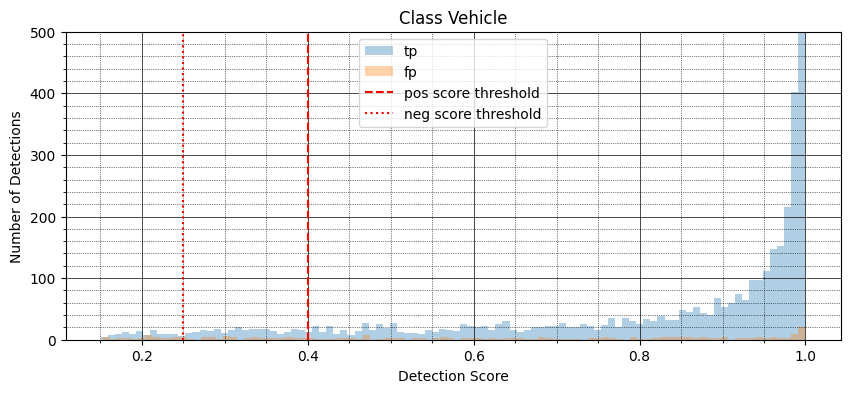

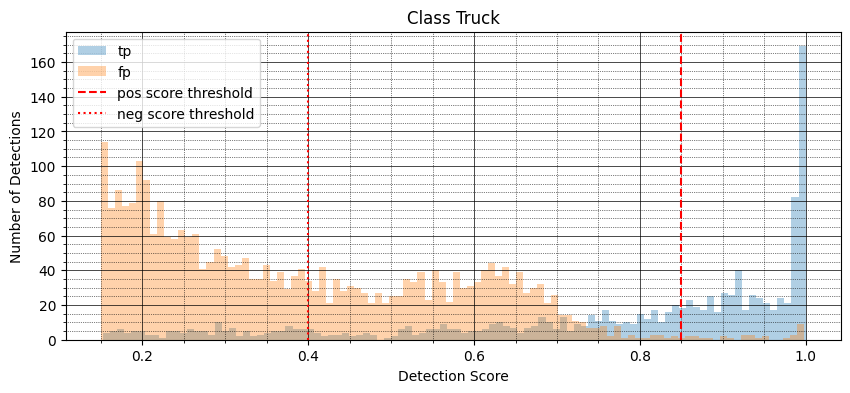

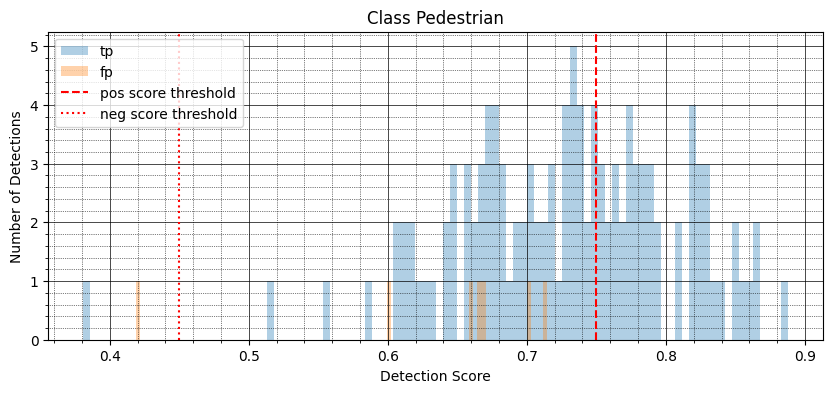

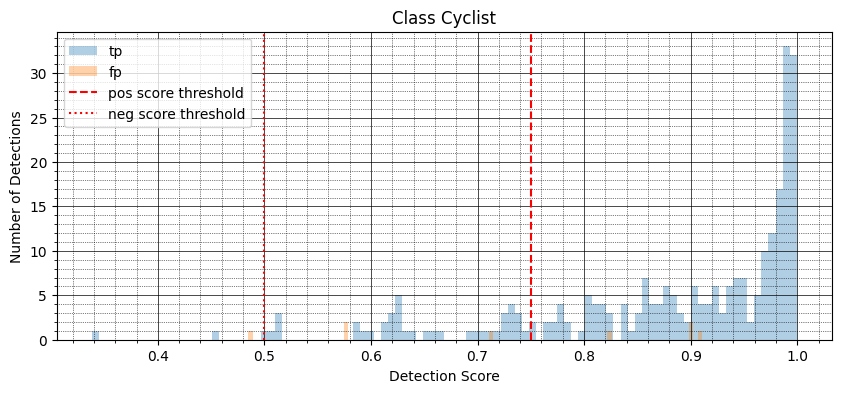

In [60]:
classes = ["Vehicle", "Truck", "Pedestrian", "Cyclist"]
iou = 0.3

for clss in classes:
    print(clss)
    detections_class = detections[detections['name'] == clss]


    print("detected objects:", len(detections_class))
    print("true positive objects:", len(detections_class[(detections_class[f'detected_{iou}'] == True)]))
    print("total number of true objects:", len(gt_labels_all[gt_labels_all['names'] == clss]))
    print("true positive recall rate(percent):", round(len(detections_class[(detections_class[f'detected_{iou}'] == True)])/len(gt_labels_all[gt_labels_all['names'] == clss])*100, 3), "%")

    pos_scorethreshmap = {
        "Vehicle": 0.4,
        "Pedestrian": 0.75,
        "Cyclist": 0.75,
        "Truck": 0.85,
    }
    neg_scorethreshmap = {
        "Vehicle": 0.25,
        "Pedestrian": 0.45,
        "Cyclist": 0.5,
        "Truck": 0.40,
    }

    pos_score_thresh = pos_scorethreshmap[clss]
    neg_score_thresh = neg_scorethreshmap[clss]


    detections_class_tp = detections_class[(detections_class[f'detected_0.1'] == True)]
    detections_class_fp = detections_class[(detections_class[f'detected_0.1'] == False)]

    plt.figure(figsize=(10, 4))
    detections_class_tp["score"].hist(bins=100, alpha=0.35, label="tp")    
    detections_class_fp["score"].hist(bins=100, alpha=0.35, label="fp")
    plt.axvline(x=pos_score_thresh, color='red', linestyle='--', label="pos score threshold")
    plt.axvline(x=neg_score_thresh, color='red', linestyle=':', label="neg score threshold")
    plt.legend()
    plt.xlabel("Detection Score")
    plt.ylabel("Number of Detections")
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.title(f"Class {clss}")
    ax = plt.gca()
    if clss == "Vehicle":
        ax.set_ylim([0, 500])
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()


### Analyze label population for each epoch on the validation set

Evaluation of ckpts is needed for this step

In [64]:
eval_folder_path = "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp_ST++truck/D16_30epochs_STzod_ft_D6_50epochs_3/eval"

#load all subfolders
subfolders = [f.path for f in os.scandir(eval_folder_path) if f.is_dir() ]
subfolders.sort()

#exclude folder eval_with_train
subfolders = [folder for folder in subfolders if "eval_with_train" not in folder]

results_df = pd.DataFrame()
for subfolder in subfolders:
    #get epoch from folder name
    epoch = int(subfolder.split("_")[-1])
    #go into first dir
    subfolder = os.path.join(subfolder, os.listdir(subfolder)[0])
    subfolder = os.path.join(subfolder, os.listdir(subfolder)[0])

    #load results.pkl
    results_path = os.path.join(subfolder, "result.pkl")

    if not os.path.exists(results_path):
        print("result.pkl not found for epoch ", epoch)
        continue
    else:
        with open(results_path, 'rb') as f:
            results = pkl.load(f)

    df = pd.DataFrame()
    df = load_detections(results_path, df, train_dataset="avltruck", eval_dataset="zod")
    df['epoch'] = epoch
    results_df = pd.concat([results_df, df], axis=0)

results_df

loaded 18282 detections on dataset zod with model trained on avltruck
loaded 18941 detections on dataset zod with model trained on avltruck
loaded 18497 detections on dataset zod with model trained on avltruck
loaded 19609 detections on dataset zod with model trained on avltruck
loaded 14148 detections on dataset zod with model trained on avltruck
loaded 16308 detections on dataset zod with model trained on avltruck
loaded 15406 detections on dataset zod with model trained on avltruck
loaded 15569 detections on dataset zod with model trained on avltruck
loaded 15402 detections on dataset zod with model trained on avltruck
loaded 19259 detections on dataset zod with model trained on avltruck
loaded 19533 detections on dataset zod with model trained on avltruck
loaded 17475 detections on dataset zod with model trained on avltruck
loaded 17762 detections on dataset zod with model trained on avltruck
loaded 16496 detections on dataset zod with model trained on avltruck
loaded 20131 detecti

,name,score,boxes_lidar,pred_labels,train_dataset,eval_dataset,frame_id,epoch
0,Vehicle,0.999436,"[2.1786242, 3.392966, 0.7979212, 4.514087, 1.9...",1,avltruck,zod,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...,1
1,Vehicle,0.991868,"[0.2733273, 8.336436, 0.78991866, 3.833947, 1....",1,avltruck,zod,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...,1
2,Vehicle,0.989537,"[17.700453, 3.0828903, 1.1661013, 4.395097, 2....",1,avltruck,zod,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...,1
3,Vehicle,0.983107,"[34.171608, 6.227892, 1.5515777, 3.6535723, 1....",1,avltruck,zod,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...,1
4,Vehicle,0.960737,"[23.830526, 7.304364, 1.354237, 3.7083278, 1.7...",1,avltruck,zod,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...,1
...,...,...,...,...,...,...,...,...
18405,Truck,0.583867,"[69.02306, -13.722009, 3.3871415, 1.7735422, 0...",4,avltruck,zod,sequences/SecondaryHighway_dgt_2021-08-19-14-3...,9
18406,Truck,0.354747,"[-4.7623653, -0.016345054, 1.7417037, 10.83989...",4,avltruck,zod,sequences/SecondaryHighway_dgt_2021-08-19-14-3...,9
18407,Truck,0.218632,"[101.86599, 36.47801, 0.34389716, 3.9929502, 1...",4,avltruck,zod,sequences/SecondaryHighway_dgt_2021-08-19-14-3...,9
18408,Truck,0.171112,"[84.619125, 6.591164, 1.1505858, 4.0135374, 1....",4,avltruck,zod,sequences/SecondaryHighway_dgt_2021-08-19-14-3...,9


In [65]:
#load gt labels
gt_labels_all = pd.DataFrame()
gt_labels_all = load_gt_labels("val")
gt_labels = gt_labels_all[gt_labels_all["dataset"] == "zod"]

#filter gt frames for frames in det
gt_labels = gt_labels[gt_labels['frame_id'].isin(results_df['frame_id'].unique())]

#calc num_detections for each class
num_detections_gt = gt_labels.groupby(['names']).size().reset_index(name='counts')

print(num_detections_gt.value_counts())

print(len(gt_labels["frame_id"].unique()))




Dropped 341 rows with NaNs
Series([], dtype: int64)
0


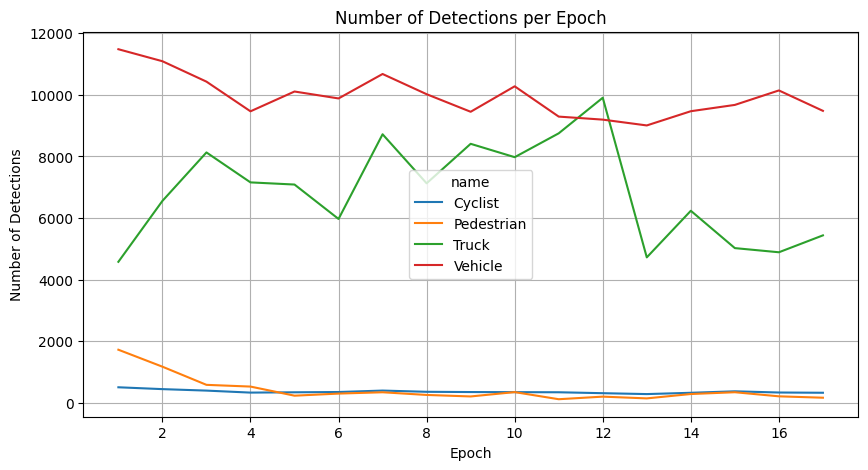

In [66]:
#plot number of detections for each class per epoch in sns, class is the hue
#calc num detections for each class
num_detections = results_df.groupby(['epoch', 'name']).size().reset_index(name='counts')
#plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=num_detections, x="epoch", y="counts", hue="name")
plt.xlabel("Epoch")
plt.ylabel("Number of Detections")
#plt.ylim([0, 2000])
plt.title("Number of Detections per Epoch")
plt.grid(True)
#print gt num detections as baseline
for i, row in num_detections_gt.iterrows():
    plt.axhline(y=row['counts'], color=sns.color_palette()[i], linestyle='--', label=row['names'], alpha=0.5)
#set ylim
#plt.gca().set_ylim([0, 1000])
plt.show()


### Analyze ps files

In [25]:
#load pseudo labels
ps_folder = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/zod_models/pvrcnnpp_ST++truck/D16_30epochs_STzod_ft_D6_50epochs_3/ps_label"
 
#load all files that start with ps
pseudo_labels = pd.DataFrame()
for file in os.listdir(ps_folder):
    if file.startswith("ps"):
        epoch = int(file.split("_")[-1].split(".")[0][1:])
        pseudo_labels = load_pseudo_labels(os.path.join(ps_folder, file), pseudo_labels, train_dataset="avltruck", eval_dataset="zod", epoch=epoch)
pseudo_labels

loaded 61103 pseudo labels on dataset zod with model trained on avltruck
loaded 62957 pseudo labels on dataset zod with model trained on avltruck
loaded 58972 pseudo labels on dataset zod with model trained on avltruck


,score,name,boxes_lidar,frame_id,eval_dataset,train_dataset,epoch
0,0.994606,Vehicle,"[2.8010950088500977, 3.1892244815826416, 0.756...",0,zod,avltruck,4
1,0.571673,Vehicle,"[120.84484100341797, 6.349390029907227, 1.5908...",0,zod,avltruck,4
2,0.808858,Vehicle,"[66.47223663330078, 1.7650796175003052, 1.0051...",0,zod,avltruck,4
3,0.355193,Unsure,"[117.8998794555664, 0.7036017179489136, 1.1866...",0,zod,avltruck,4
4,0.285201,Unsure,"[108.33291625976562, 8.666638374328613, 1.1627...",0,zod,avltruck,4
...,...,...,...,...,...,...,...
183027,0.941792,Vehicle,"[59.41789245605469, 5.382844924926758, 1.64559...",5333,zod,avltruck,0
183028,0.564733,Unsure,"[50.03185272216797, -18.175033569335938, 0.883...",5333,zod,avltruck,0
183029,0.489485,Unsure,"[21.656787872314453, -17.77408218383789, 1.092...",5333,zod,avltruck,0
183030,0.483673,Unsure,"[30.037723541259766, -28.67414093017578, 0.543...",5333,zod,avltruck,0


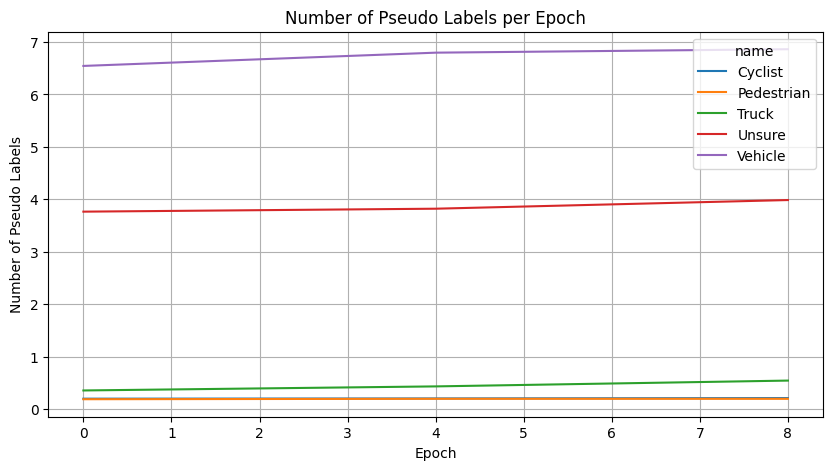

In [27]:
#print number of pseudo labels for each class per epoch

#calc num detections for each class
num_pseudo_labels = pseudo_labels.groupby(['epoch', 'name']).size().reset_index(name='counts')

#normalize by number of frames
num_frames_per_epoch = pseudo_labels["frame_id"].nunique()
num_pseudo_labels['counts'] = num_pseudo_labels['counts']/num_frames_per_epoch

#plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=num_pseudo_labels, x="epoch", y="counts", hue="name")
plt.xlabel("Epoch")
plt.ylabel("Number of Pseudo Labels")
plt.title("Number of Pseudo Labels per Epoch")
plt.grid(True)
plt.show()
